In [1]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce
from tqdm import tqdm

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [51]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths[8]

('positive_images', '..\\dataset\\positive_images')

Preparing a dataframe to summarize the dataset

In [3]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
277,negatives,50996083_71c1a60d57c5322f_MG_R_ML_ANON.tif
114,negatives,20587320_e634830794f5c1bd_MG_L_CC_ANON.tif
69,positives,24065530_d8205a09c8173f44_MG_L_ML_ANON.tif
247,negatives,50993841_de5e8d61e501a71b_MG_L_CC_ANON.tif
90,positives,50999432_f62fbf38fb208316_MG_L_ML_ANON.tif
404,negatives,53587508_d2befe622e188943_MG_R_CC_ANON.tif
340,negatives,51048945_f3e93e889a7746f0_MG_L_CC_ANON.tif
322,negatives,50998413_1f139436acfc5467_MG_L_ML_ANON.tif
16,positives,20588536_bf1a6aaadb05e3df_MG_L_ML_ANON.tif
32,positives,22580680_fe7d005dcbbfb46d_MG_L_CC_ANON.tif


Dataset Summary

In [4]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [5]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

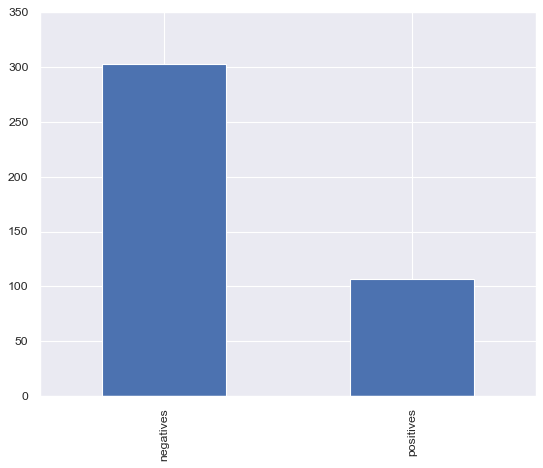

In [6]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

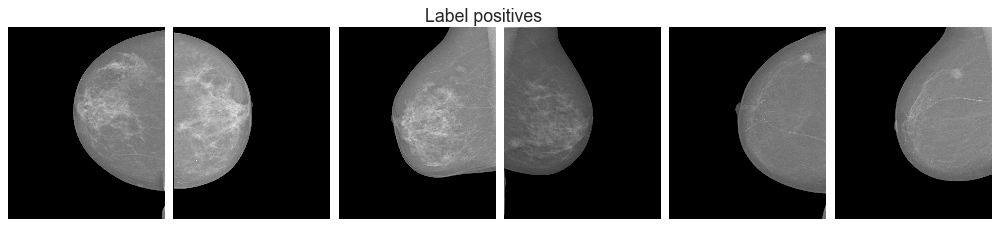

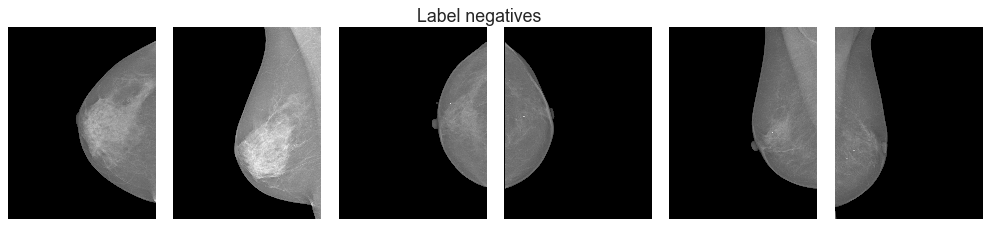

In [7]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

2023-05-12 20:33:44.897 | INFO     | preprocessing:fit:96 - Started processing pipeline.
100%|███████████████████████████| 1/1 [00:00<00:00,  2.43it/s]
2023-05-12 20:33:45.321 | INFO     | preprocessing:fit:147 - Finished processing 107 files in approximately 0.424 seconds.


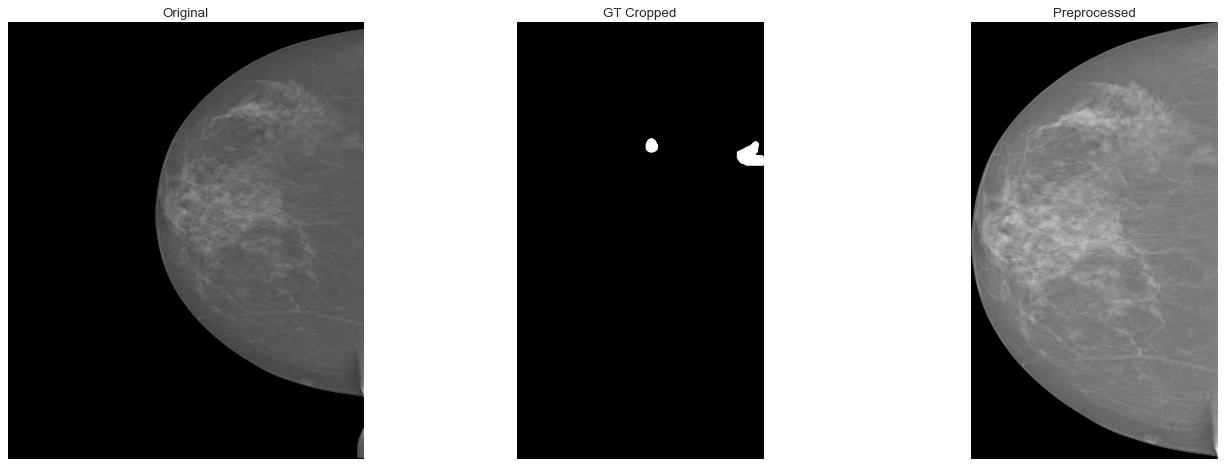

In [53]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[8][1],
                 ground_truth_path = dataset_folder_paths[0][1],
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

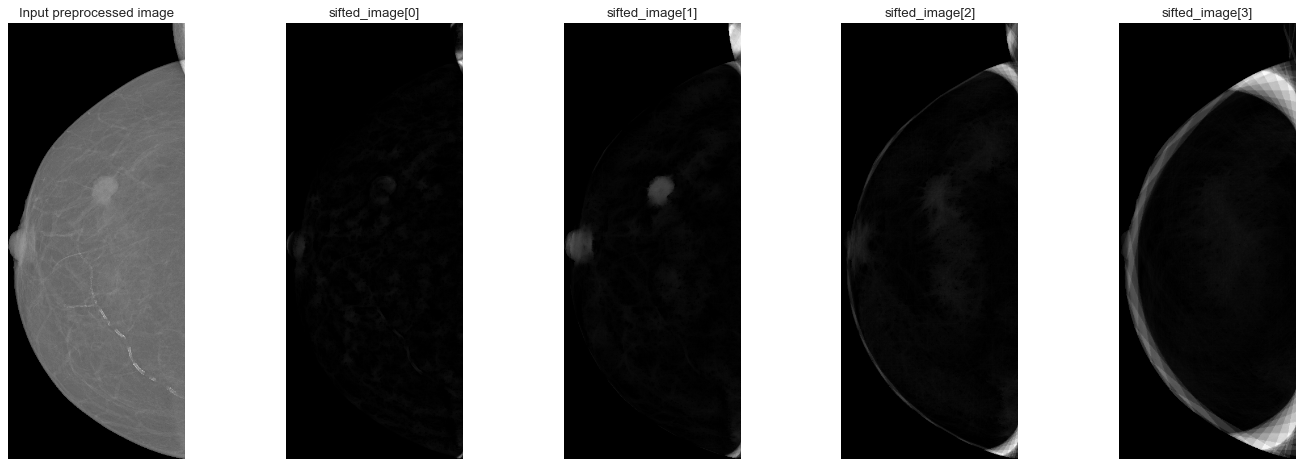

In [73]:
# image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'
# image_input_name = '22670324_98429c0bdf78c0c7_MG_R_ML_ANON.tif'

input_image = cv2.imread(
    os.path.join(
        os.path.dirname("../dataset/processed/positive_images/"), 
        image_input_name
    ), cv2.IMREAD_GRAYSCALE)

sifted_image = mms.multi_scale_morphological_sifters(input_image,4,18,15,3689,70/1000)

imgs = {
    "Input preprocessed image": input_image,
    "sifted_image[0]":sifted_image[0],
    "sifted_image[1]":sifted_image[1],
    "sifted_image[2]":sifted_image[2],
    "sifted_image[3]":sifted_image[3],
}
display.plot_figures(imgs, 1, 5)

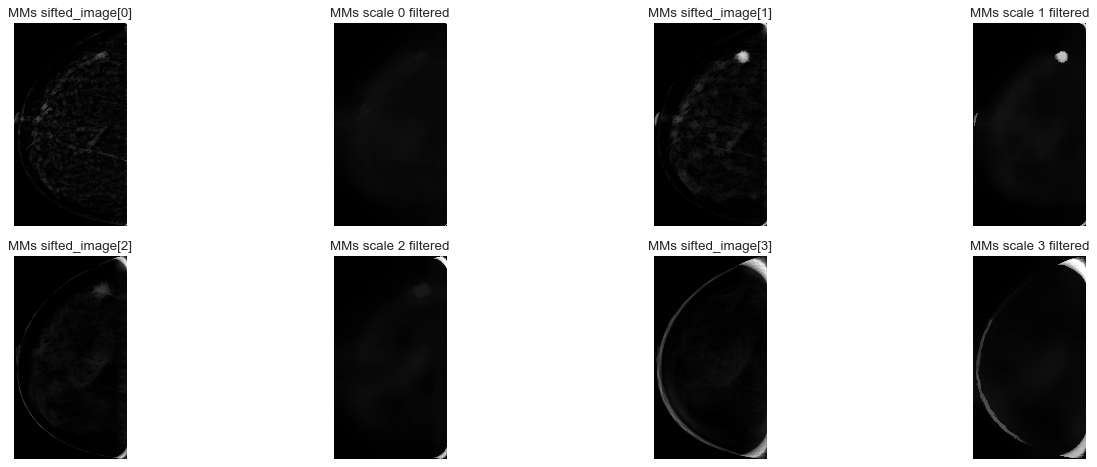

In [63]:
def mean_shift_filter(image, spatial_radius, range_radius):
    """
    Apply mean shift filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of type uint16 with shape (height, width)
    - spatial_radius: int, spatial distance (in pixels) to consider for the filter
    - range_radius: int, color distance to consider for the filter

    Returns:
    - filtered_image: 2D numpy array of type uint16 with shape (height, width),
                      the result of the filter
    """

    # Convert image to float32 for better precision
    image_float = image.astype(np.float32)

    # Convert image to uint8 for OpenCV
    image_uint8 = cv2.convertScaleAbs(image_float / np.max(image_float) * 255)

    # Convert 2-channel grayscale image to 3-channel grayscale image
    image_3ch = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2BGR)

    # Apply mean shift filter using OpenCV
    filtered_image_uint8 = cv2.pyrMeanShiftFiltering(image_3ch, spatial_radius, range_radius)

    # Convert the filtered image back to uint16
    filtered_image_float = cv2.cvtColor(filtered_image_uint8, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0 * np.max(image_float)
    filtered_image = filtered_image_float.astype(np.uint16)

    return filtered_image


# Display the enhanced and tophat image
imgs = {
    "MMs sifted_image[0]": sifted_image[0],
    "MMs scale 0 filtered": mean_shift_filter(sifted_image[0], spatial_radius=45, range_radius=60),
    "MMs sifted_image[1]": sifted_image[1],
    "MMs scale 1 filtered": mean_shift_filter(sifted_image[1], spatial_radius=45, range_radius=60),
    "MMs sifted_image[2]": sifted_image[2],
    "MMs scale 2 filtered": mean_shift_filter(sifted_image[2], spatial_radius=45, range_radius=60),
    "MMs sifted_image[3]": sifted_image[3],
    "MMs scale 3 filtered": mean_shift_filter(sifted_image[3], spatial_radius=45, range_radius=60),
    } # 15, 100
display.plot_figures(imgs, 2, 4)


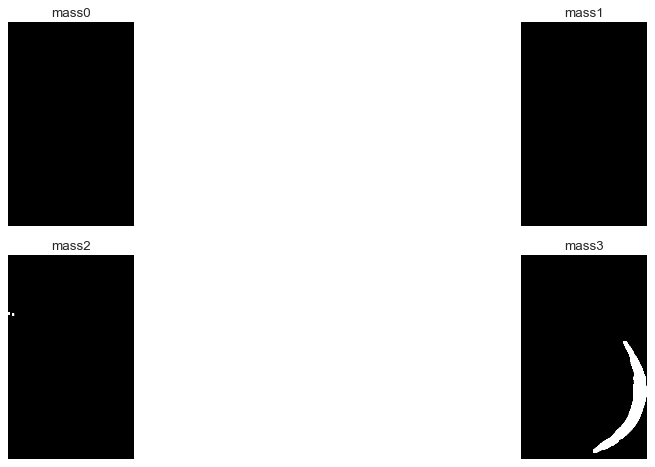

In [131]:
def contour_touches_border(contour, image_width, image_height, border_margin=0):
    for point in contour:
        x, y = point[0]

        # Check if the point is on or near the image border
        if x <= border_margin or x >= image_width - 1 - border_margin or y <= border_margin or y >= image_height - 1 - border_margin:
            return True

    return False

def eliminate_by_area(image, min_area, max_area):
        # Convert to uint8
        image = (image / np.max(image) * 255).astype(np.uint8)
        
        # Apply mean shift filtering to enhance tumor features
        filtered = mean_shift_filter(image, spatial_radius=45, range_radius=60)

        # Normalize the filtered image to improve contrast
        normalized_image = cv2.normalize(filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Apply thresholding
        # _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresh = cv2.adaptiveThreshold(normalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)

        # Perform morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        opened = cv2.morphologyEx(cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel), cv2.MORPH_OPEN, kernel)

        # Find contours of thresholded image
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a blank image to draw contours on
        result = np.zeros_like(opened)

        # Loop through contours and eliminate those outside the desired area range
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if min_area < area < max_area:
                cv2.drawContours(result, [cnt], 0, (255, 255, 255), -1)
                
        # remove any lines resulted from the contours by performing morphological opening to remove lines
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        
        result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel)

        return result

# image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'
# image_input_name = '22670324_98429c0bdf78c0c7_MG_R_ML_ANON.tif'
image_input_name = '20588562_bf1a6aaadb05e3df_MG_L_CC_ANON.tif'

input_image = cv2.imread(
    os.path.join(
        os.path.dirname("../dataset/processed/positive_images/"), 
        image_input_name
    ), cv2.IMREAD_GRAYSCALE)

sifted_image = mms.multi_scale_morphological_sifters(input_image,4,18,15,3689,70/1000)

# Find the average min and max area of mass sizes from the ground truth, calculate pixel wise and update the function call 
mass0 = eliminate_by_area(sifted_image[0], min_area=800, max_area=751132.0) 
mass1 = eliminate_by_area(sifted_image[1], min_area=800, max_area=751132.0) 
mass2 = eliminate_by_area(sifted_image[2], min_area=800, max_area=751132.0) 
mass3 = eliminate_by_area(sifted_image[3], min_area=800, max_area=751132.0) 

# Display the enhanced and tophat image
imgs = {
    "mass0":mass0,
    "mass1":mass1,
    "mass2":mass2,
    "mass3":mass3
}
display.plot_figures(imgs, 2, 2)

In [ ]:
# Instead of MLO Thresholding
# superpixels - non-parametric approach
# k means clusturing - K levels
# means clusturing - reguarization params


# Features extraction
# GLCM features 10-15 + statistics of mass region (contrast average value)

# Shape features 10
# LBP 
# SIFTs

# Gabor wavelets ~ good to charectirize textures in iris


# Features reduction - LDA 

In [ ]:
# # Set the paths to the positive images and groundtruth folders
# positive_images_path = '../dataset/positive_images'
# groundtruth_path = '../dataset/groundtruth'

# # Get a list of all the tif images in the positive images folder
# tif_images = [f for f in os.listdir(positive_images_path) if f.endswith('.tif')]

In [ ]:
# tif_images

In [ ]:
# def mean_shift_filter(image, spatial_radius=40, color_radius=80):
#     # Normalize the image to the range [0, 255]
#     normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # Convert the image to BGR color space
#     bgr_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
    
#     # Apply mean shift filtering
#     filtered_image = cv2.pyrMeanShiftFiltering(bgr_image, spatial_radius, color_radius)
    
#     # Convert the filtered image to grayscale
#     grayscale_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    
#     return grayscale_image

In [ ]:
# plt.rcParams['figure.max_open_warning'] = False

# for image_input_name in tif_images:

#     normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
#         image_input_name, 
#         plot=False,
#     )

#     # Reading the same processed image (ovarlayed version) for visual comparison
#     overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
#     overlay_image = cv2.imread(overlay_image_dataset)

#     # Display the enhanced and tophat image
#     imgs = {
#         "MMs enhanced scale 0": enhanced_images[0],
#         "MMs scale 0 filtered": mean_shift_filter(enhanced_images[0]),
#         "MMs enhanced scale 1": enhanced_images[1],
#         "MMs scale 1 filtered": mean_shift_filter(enhanced_images[1]),
#         "MMS normalized summed image": normalized_image,
#         "MMs scale 0 filtered": mean_shift_filter(normalized_image)
# #         "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
#     }
#     display.plot_figures(imgs, 2, 3)

Savving all MMs scales and summed images in a directory

In [89]:
mms_output_dir = r"..\\dataset\\output\\mms"
segmentation_output_dir = r"..\\dataset\\output\\segmentation"

if not os.path.isdir(mms_output_dir):
    os.makedirs(mms_output_dir)
    logger.info(f"New directory created '{mms_output_dir}'")
    
if not os.path.isdir(segmentation_output_dir):
    os.makedirs(segmentation_output_dir)
    logger.info(f"New directory created '{segmentation_output_dir}'")

In [90]:
# RUN ONLY ONCE
positive_images_dir = r"..\\dataset\\positive_images"

for idx, file_name in tqdm(enumerate(os.listdir(positive_images_dir))):
    file_dir = ''

    input_image = cv2.imread(
        os.path.join(
            os.path.dirname("../dataset/processed/positive_images/"), 
            file_name
        ), cv2.IMREAD_GRAYSCALE)
    
    sifted_image = mms.multi_scale_morphological_sifters(input_image,4,18,15,3689,70/1000)    
    
    for index, img in enumerate(sifted_image):
        # Scale i image will have a file name tailed with _i        
        file_dir = os.path.join(mms_output_dir, file_name.split('.tif')[0] + '_' + str(index) + '.tif')
        cv2.imwrite(file_dir, sifted_image[index].astype(np.uint16))
        


107it [00:33,  3.23it/s]


Segmenting all MMs outputs

In [92]:
for idx, file_name in tqdm(enumerate(os.listdir(mms_output_dir))):
    input_image = cv2.imread(os.path.join(mms_output_dir, file_name), cv2.IMREAD_GRAYSCALE)
    mass = eliminate_by_area(input_image, min_area=800, max_area=751132.0)     
    file_dir = os.path.join(segmentation_output_dir, file_name.split('.tif')[0] + '.tif')
    
    cv2.imwrite(file_dir, mass)


428it [05:22,  1.33it/s]


In [81]:
# Remove cropping from pre-processing, ground truth are not cropped
# keep modifying parameters
# remove contours with rectangular shape either horizontal or vertical